# Quickstart using Python

In this tutorial you'll learn how to read GIRAFE files in Python using xarray and perform a simple computation.

## Collect Input Files

Collect daily GIRAFE files in your data directory

In [1]:
from pathlib import Path

data_dir = Path("/my/girafe/data")
filenames = data_dir.glob("PREdm*.nc")

## Create Dataset

Concatenate and merge files into an xarray dataset. Note that this does not load the data into memory until actually needed. See https://docs.xarray.dev/en/stable/user-guide/dask.html#dask-io 

In [2]:
import xarray as xr

ds = xr.open_mfdataset(filenames, concat_dim="time", combine="nested")
ds = ds.sortby("time")
ds

<xarray.Dataset> Size: 16GB
Dimensions:                      (time: 7670, nv: 2, lat: 180, lon: 360)
Coordinates:
  * time                         (time) datetime64[ns] 61kB 2002-01-01 ... 20...
  * lat                          (lat) float64 1kB -89.5 -88.5 ... 88.5 89.5
  * lon                          (lon) float64 3kB -179.5 -178.5 ... 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds                    (time, nv) datetime64[ns] 123kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds                     (time, lat, nv) float64 22MB dask.array<chunksize=(1, 180, 2), meta=np.ndarray>
    lon_bnds                     (time, lon, nv) float64 44MB dask.array<chunksize=(1, 360, 2), meta=np.ndarray>
    record_status                (time) int8 8kB dask.array<chunksize=(1,), meta=np.ndarray>
    precipitation                (time, lat, lon) float32 2GB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    sampling_error               (time, lat, lon) float32 2GB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    sampling_error_quality_flag  (time, lat, lon) float32 2GB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    num_obs_fraction             (time, lat, lon) float64 4GB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    num_obs_rate                 (time, lat, lon) float64 4GB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    snow_flag                    (time, lat, lon) float32 2GB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes: (12/32)
    title:                      Global Interpolated RAinFall Estimation (GIRAFE)
    summary:                    This file contains data from the Precipitatio...
    id:                         DOI:10.5676/EUM_SAF_CM/GIRAFE/V001
    product_version:            1.0
    creator_name:               DE/DWD
    creator_email:              contact.cmsaf@dwd.de
    ...                         ...
    platform_vocabulary:        GCMD Platforms, Version 16.5
    instrument:                 SSM/I > Special Sensor Microwave/Imager,TMI >...
    instrument_vocabulary:      GCMD Instruments, Version 16.5
    variable_id:                precipitation
    CMSAF_processor:            girafe-app-v1.5.5
    license:                    The CM SAF data are owned by EUMETSAT and are...

## Mask Cells affected by Snow/Ice

Snow- and ice-covered scenes reveal an issue of precipitation measurements with microwave
sensors. Relevant amounts of precipitation are missed over such areas.

In [3]:
ds = ds.where(ds["snow_flag"] == 0)

## Compute Something

1. Timeseries of global (area-weighted) mean precipitation

In [4]:
import numpy as np

weights = np.cos(np.deg2rad(ds["lat"]))
global_mean = ds["precipitation"].weighted(weights).mean(dim=("lon", "lat"))
global_mean.attrs = {
    "long_name": "Global area-weighted mean precipitation",
    "units": "mm"
}
global_mean

<xarray.DataArray 'precipitation' (time: 7670)> Size: 61kB
dask.array<truediv, shape=(7670,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 61kB 2002-01-01 2002-01-02 ... 2022-12-31
Attributes:
    long_name:  Global area-weighted mean precipitation
    units:      mm

2. All-time mean precipitation in each grid cell

In [5]:
all_time_mean = ds["precipitation"].mean(dim="time")
all_time_mean.attrs = {
    "long_name": "All-time mean precipitation",
    "units": "mm"
}
all_time_mean

<xarray.DataArray 'precipitation' (lat: 180, lon: 360)> Size: 259kB
dask.array<mean_agg-aggregate, shape=(180, 360), dtype=float32, chunksize=(180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    long_name:  All-time mean precipitation
    units:      mm

## Plot Results

1. Plot timeseries of global mean precipitation.

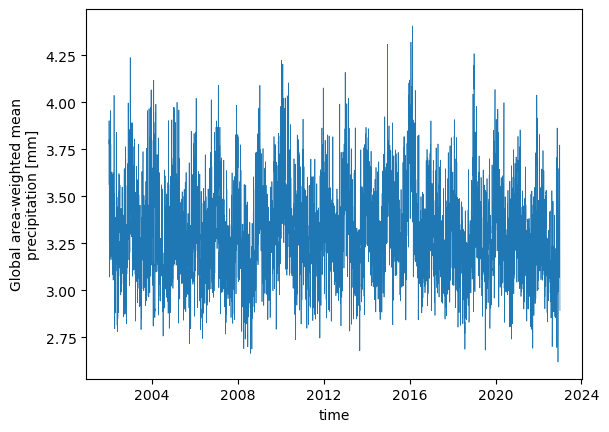

In [6]:
import matplotlib.pyplot as plt

im = global_mean.plot(linewidth=0.5)

2. Plot all-time mean precipitation map in Robinson projection using a logarithmic colormap.

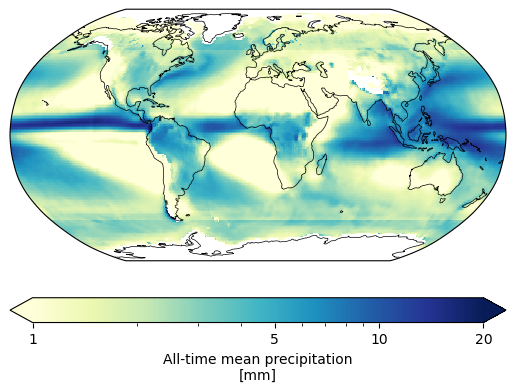

In [7]:
import cartopy.crs as ccrs
from matplotlib import colors
from matplotlib import ticker

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.Robinson()})
ax.coastlines(linewidth=0.5)
im = all_time_mean.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  # GIRAFE is plate-carree
    cmap="YlGnBu",
    norm=colors.LogNorm(),
    vmin=1,
    vmax=20,
    cbar_kwargs={
        "location": "bottom",
        "format": "%d",
        "ticks": ticker.FixedLocator([1, 5, 10, 20]),
        "pad": 0.1
    }
)